<a href="https://colab.research.google.com/github/gianspi/iot2022airquality/blob/main/forecast_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install influxdb-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 23.1 MB/s eta 0:00:00


In [2]:
from influxdb_client import InfluxDBClient, Point, WriteOptions
from prophet import Prophet, diagnostics

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

import itertools
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time
import datetime 
from datetime import timedelta
import math
import numpy as np
import scipy.stats as st

In [3]:
AIR_QUALITY_MEASUREMENT = '"air_quality"'
FORECAST_MEASUREMENT = '"forecast"'
forecast = 'forecast'
FIELDS_TO_FORECAST = ['hum', 'temp', 'conc']
TAGS = ['sensorID', 'lat', 'lon']

COLUMNS_TO_BE_REMOVED = ['result', 'table', '_start', '_stop', '_measurement']

TIME = '_time'
PD_TIME = 'ds'

In [4]:
token = "LUaijeA_-hxGtLkz9axuiCVt51pgGPakizsI7wESL5QAe0vEbr7z1CUoK42Jj0s8lrKT6UWzDmi32hc9E8g-Tw--"
BUCKET = '"Air_Quality"'
org = "IoT_Team"
ngrok_url = "https://aaa9-2001-b07-646a-b07c-7d93-dc7d-c845-841c.ngrok-free.app"
client = InfluxDBClient(url=ngrok_url, token=token, debug=False, org=org)
query_api = client.query_api()

In [5]:
def query(measurement, field) :
  query = ' from(bucket:' + BUCKET + ') ' \
          ' |> range(start: -1d) ' \
          ' |> filter(fn: (r) => r._measurement == ' + measurement + ') ' \
          ' |> filter(fn: (r) => r._field == "' + field + '") ' \
          ' |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value") '

  result = client.query_api().query_data_frame(query)
  
  if len(result.index) > 0 : 
    result = result.rename(columns={TIME : PD_TIME})

    result = result.drop(columns=COLUMNS_TO_BE_REMOVED)
    result = result.drop(columns=TAGS)

    result['ds'] = result['ds'].dt.tz_localize(None)
  else :
    result = None

  return result

In [14]:
df_prova = query(AIR_QUALITY_MEASUREMENT, "packet_number")
print(df_prova)

                          ds  packet_number
0    2023-06-14 17:57:42.620              0
1    2023-06-14 17:58:43.615              1
2    2023-06-14 17:59:47.243              2
3    2023-06-14 18:02:00.618              0
4    2023-06-14 18:03:02.615              1
...                      ...            ...
1318 2023-06-15 17:01:58.615           1349
1319 2023-06-15 17:03:00.615           1350
1320 2023-06-15 17:04:01.615           1351
1321 2023-06-15 17:05:02.615           1352
1322 2023-06-15 17:06:04.615           1353

[1323 rows x 2 columns]


In [9]:
def analyse_field (field):
  global mse_array
  global forecasted_array
  global expected_array
  global forecasted
  global expected
  mse_array = []
  forecasted_array = []
  expected_array = []
  forecasted = []
  expected = []
  
  print("--------------------------------------------------------------------------------------")
  print(field)

  df = query(AIR_QUALITY_MEASUREMENT, field)
  df = df.rename(columns={field : 'y'})

  train, test = train_test_split(df, test_size=0.2, shuffle=False)

  m = Prophet(
      yearly_seasonality=False,
      weekly_seasonality=False,
      daily_seasonality=False,
      n_changepoints=35,
      changepoint_range=1,
      changepoint_prior_scale=0.01
  ).fit(train)

  
  test_interval = int((test.iloc[-1]['ds'].timestamp() - test.iloc[0]['ds'].timestamp()) / 60)
  test_interval = test_interval + 1

  future = m.make_future_dataframe(periods=test_interval, freq=DateOffset(minutes=1))
  forecast = m.predict(future)

  forecast['ds'] = forecast.ds.dt.floor('min')
  test['ds'] = test.ds.dt.floor('min')

  metric = test.set_index('ds')[['y']].join(forecast.set_index('ds').yhat).reset_index()

  metric = metric.dropna()
  
  mse = mean_squared_error(metric['y'], metric['yhat'])
  mse_array.append(mse)
  
  expected_array.append(metric['y'].tolist())
  forecasted_array.append(metric['yhat'].tolist())


  forecasted = list(itertools.chain.from_iterable(forecasted_array))
  expected = list(itertools.chain.from_iterable(expected_array))

--------------------------------------------------------------------------------------
hum


DEBUG:cmdstanpy:input tempfile: /tmp/tmp99y4r7dh/hcjos5km.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp99y4r7dh/f5_0d81v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4258', 'data', 'file=/tmp/tmp99y4r7dh/hcjos5km.json', 'init=/tmp/tmp99y4r7dh/f5_0d81v.json', 'output', 'file=/tmp/tmp99y4r7dh/prophet_modelhie62tlz/prophet_model-20230615170403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing




Evaluating hum


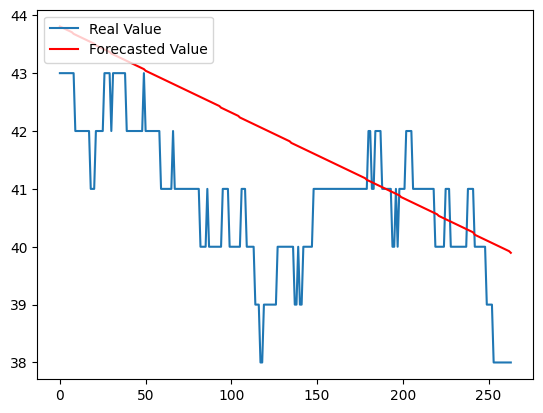

mse
2.2417226673997956
Test RMSE: 1.497
MAE: 1.213170
Mean:  41.85486553638038
Standard Deviation:  1.1235471632943808
Confidence intervals:  (41.71844974153682, 41.99128133122391)
--------------------------------------------------------------------------------------
temp


<ipython-input-13-10e52bc7014b>:50: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  res = st.t.interval(alpha=0.95, df=len(forecasted)-1, loc=np.mean(forecasted), scale=st.sem(forecasted))
DEBUG:cmdstanpy:input tempfile: /tmp/tmp99y4r7dh/vw9uzlbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp99y4r7dh/l5z0oz1c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70571', 'data', 'file=/tmp/tmp99y4r7dh/vw9uzlbi.json', 'init=/tmp/tmp99y4r7dh/l5z0oz1c.json', 'output', 'file=/tmp/tmp99y4r7dh/prophet_model2hkynj6b/prophet_model-20230615170404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing




Evaluating temp


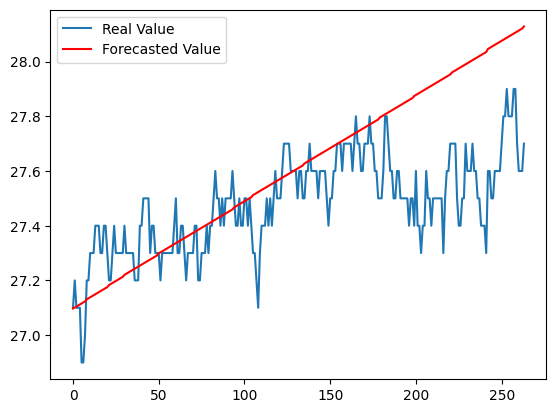

mse
0.06455667974737828
Test RMSE: 0.254
MAE: 0.187749
Mean:  27.611667587746222
Standard Deviation:  0.29621771079884474
Confidence intervals:  (27.575702231074523, 27.64763294441792)
--------------------------------------------------------------------------------------
conc


<ipython-input-13-10e52bc7014b>:50: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  res = st.t.interval(alpha=0.95, df=len(forecasted)-1, loc=np.mean(forecasted), scale=st.sem(forecasted))
DEBUG:cmdstanpy:input tempfile: /tmp/tmp99y4r7dh/5dqqku6b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp99y4r7dh/d8hqf65m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6413', 'data', 'file=/tmp/tmp99y4r7dh/5dqqku6b.json', 'init=/tmp/tmp99y4r7dh/d8hqf65m.json', 'output', 'file=/tmp/tmp99y4r7dh/prophet_model98p1wp0e/prophet_model-20230615170406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
1



Evaluating conc


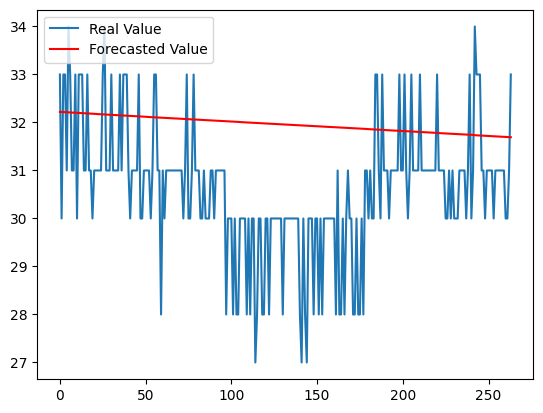

mse
3.6197493946400736
Test RMSE: 1.903
MAE: 1.631114
Mean:  31.95727561502762
Standard Deviation:  0.1516962944693952
Confidence intervals:  (31.93885736676809, 31.975693863287177)


<ipython-input-13-10e52bc7014b>:50: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  res = st.t.interval(alpha=0.95, df=len(forecasted)-1, loc=np.mean(forecasted), scale=st.sem(forecasted))


In [13]:
APE = []
i = 0
for field in FIELDS_TO_FORECAST :
	analyse_field(field)
	
	print("\n\nEvaluating " + field)
	plt.plot(expected, label="Real Value")
	plt.plot(forecasted, "-r", label="Forecasted Value")

	plt.legend(loc="upper left")
	plt.show()
	
	mse = mean_squared_error(expected, forecasted)
	print('mse')
	print(mse)
	rmse = math.sqrt(mean_squared_error(expected, forecasted))
	print('Test RMSE: %.3f' % rmse)

	mae = mean_absolute_error(expected, forecasted)
	print('MAE: %f' % mae)

	mean = sum(forecasted) / len(forecasted)
	print("Mean: ", mean)
 
	std = np.std(forecasted)
	print("Standard Deviation: ", std)

	res = st.t.interval(alpha=0.95, df=len(forecasted)-1, loc=np.mean(forecasted), scale=st.sem(forecasted))

	print("Confidence intervals: ", res)